<a href="https://colab.research.google.com/github/Ahmed-M-Elshazly/Homework-6/blob/main/Homework_6_Problem_3_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework1
#Problem 1-a
#Ahmed Elshazly
#801420724

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score
import time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=True, download=True)
val_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
img, label = train_dataset[100]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 8, 'ship')

In [ ]:
len(train_dataset)

50000

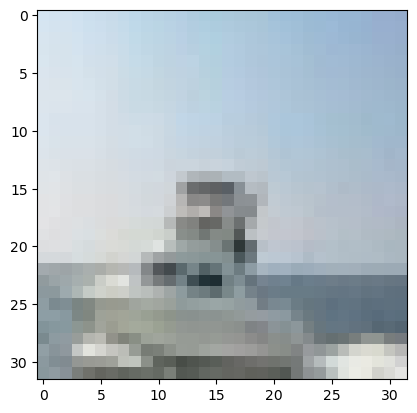

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=True, download=False,
                          transform=transforms.ToTensor())
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

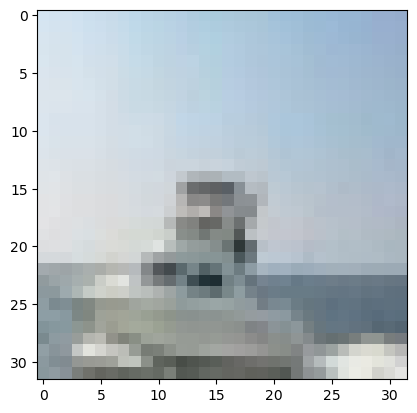

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))  # <1>
plt.show()

In [ ]:
train_mean=imgs.view(3, -1).mean(dim=1)
train_std=imgs.view(3, -1).std(dim=1)
print(train_mean)
print(train_std)


tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [ ]:
transforms.Normalize(train_mean, train_std)


Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

In [ ]:
transformed_train_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
train_loader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=64, shuffle=True)

In [ ]:
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, 10),
).to(device)

In [ ]:
val_dataset = torchvision.datasets.CIFAR10('../data-unversioned/p1ch7/', train=False, download=False,
                          transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in val_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 10000])

In [ ]:
val_mean=imgs.view(3, -1).mean(dim=1)
val_std=imgs.view(3, -1).std(dim=1)
print(val_mean)
print(val_std)


tensor([0.4942, 0.4851, 0.4504])
tensor([0.2467, 0.2429, 0.2616])


In [ ]:
transforms.Normalize(val_mean, val_std)

Normalize(mean=tensor([0.4942, 0.4851, 0.4504]), std=tensor([0.2467, 0.2429, 0.2616]))

In [ ]:
transformed_val_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
val_loader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=64, shuffle=False)

Epoch: 1, Train Loss: 1.955331, Epoch Runtime: 8.72 seconds, Train Accurracy : 0.330260, Validation Accuracy : 0.364500
Epoch: 2, Train Loss: 1.771454, Epoch Runtime: 8.62 seconds, Train Accurracy : 0.365290, Validation Accuracy : 0.377900
Epoch: 3, Train Loss: 1.697623, Epoch Runtime: 8.52 seconds, Train Accurracy : 0.388040, Validation Accuracy : 0.388633
Epoch: 4, Train Loss: 1.647729, Epoch Runtime: 8.79 seconds, Train Accurracy : 0.405290, Validation Accuracy : 0.396375
Epoch: 5, Train Loss: 1.603378, Epoch Runtime: 8.55 seconds, Train Accurracy : 0.420412, Validation Accuracy : 0.403840
Epoch: 6, Train Loss: 1.561916, Epoch Runtime: 8.32 seconds, Train Accurracy : 0.433980, Validation Accuracy : 0.411167
Epoch: 7, Train Loss: 1.524601, Epoch Runtime: 8.65 seconds, Train Accurracy : 0.446960, Validation Accuracy : 0.417414
Epoch: 8, Train Loss: 1.487658, Epoch Runtime: 8.35 seconds, Train Accurracy : 0.458832, Validation Accuracy : 0.422362
Epoch: 9, Train Loss: 1.452410, Epoch Ru

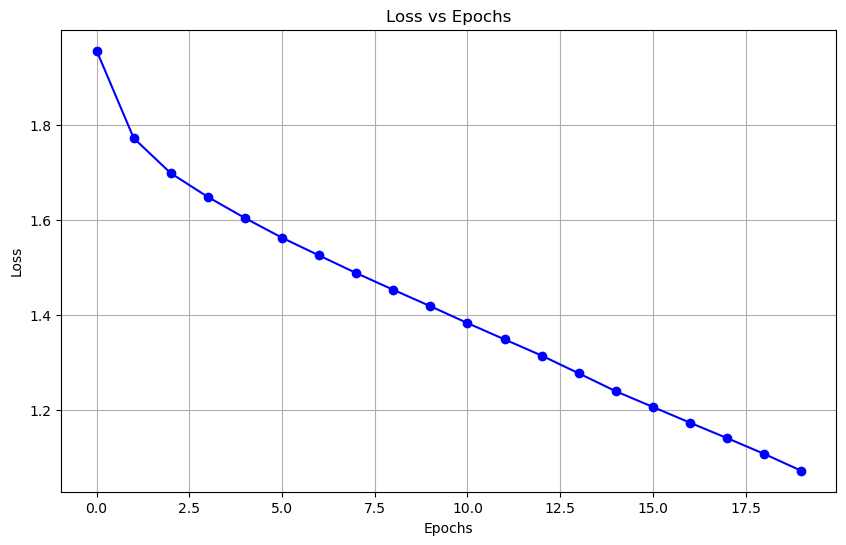

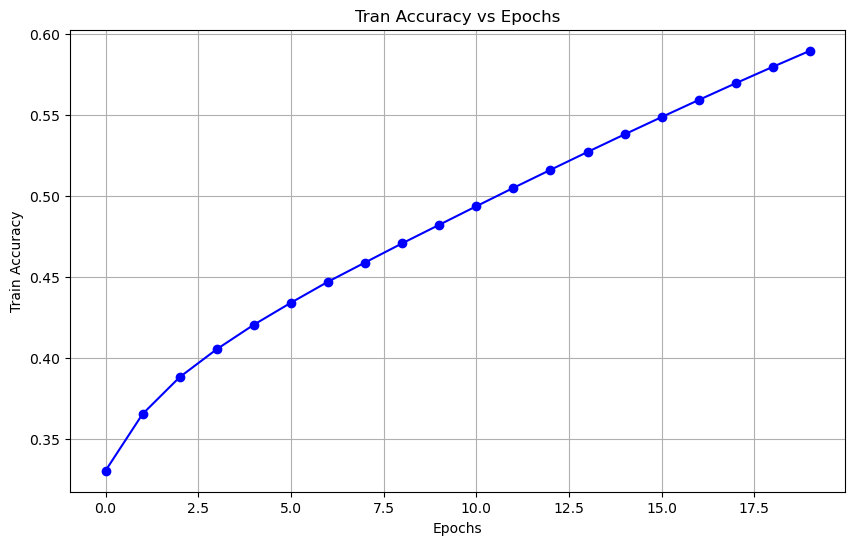

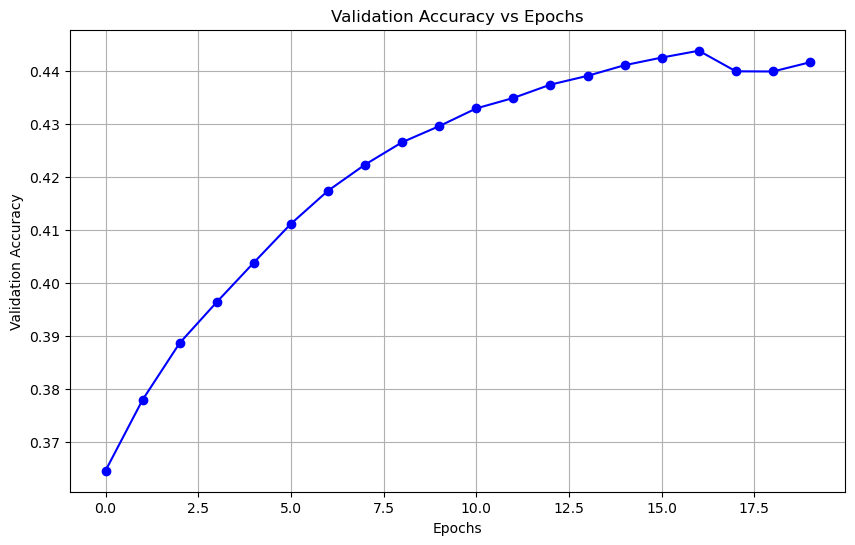

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Training loop
num_epochs = 20
total_start_time = time.time()
losses=[]
train_accs=[]
val_accs=[]
tr_correct=0
tr_total=0
val_correct=0
val_total=0

for epoch in range(num_epochs):
    start_time = time.time()
    counter=0
    cum_loss=0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size=imgs.shape[0]
        outputs=model(imgs.view(batch_size,-1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs=model(imgs.view(batch_size,-1))
        _,predicted=torch.max(outputs,dim=1)
        tr_total+=labels.shape[0]
        tr_correct+=int((predicted==labels).sum())
        counter+=1
        cum_loss+=loss

    tr_acc=tr_correct/tr_total
    epoch_loss=cum_loss/counter

    for imgs, labels in val_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      batch_size=imgs.shape[0]
      outputs=model(imgs.view(batch_size,-1))
      _,predicted=torch.max(outputs,dim=1)
      val_total+=labels.shape[0]
      val_correct+=int((predicted==labels).sum())

    val_acc=val_correct/val_total



    end_time = time.time()
    training_time = end_time - start_time
    print(f"Epoch: {epoch+1}, Train Loss: {float(epoch_loss):.6f}, Epoch Runtime: {training_time:.2f} seconds, Train Accurracy : {float(tr_acc):.6f}, Validation Accuracy : {float(val_acc):.6f}")
    losses.append(float(epoch_loss))
    train_accs.append(float(tr_acc))
    val_accs.append(float(val_acc))


# Print total training time
total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
# Plotting loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses, marker='o', linestyle='-', color='b')
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Plotting train accur vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_accs, marker='o', linestyle='-', color='b')
plt.title("Tran Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), val_accs, marker='o', linestyle='-', color='b')
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


In [ ]:
transformed_val_dataset = torchvision.datasets.CIFAR10(
    '../data-unversioned/p1ch7/', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean,
                             train_std)
    ]))
val_loader = torch.utils.data.DataLoader(transformed_val_dataset, batch_size=10000, shuffle=False)

In [ ]:

with torch.no_grad():
  for imgs, labels in val_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      batch_size=imgs.shape[0]
      outputs=model(imgs.view(batch_size,-1))
      _,predicted=torch.max(outputs,dim=1)
      cm = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
      print(f"Confusion Matrix:\n{cm}")
      print("Accuracy:", metrics.accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy()))
      print("Precision:", metrics.precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted'))
      print("Recall:", metrics.recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted'))
      print("F1 Score:", metrics.f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted'))
      report = classification_report(labels.cpu().numpy(), predicted.cpu().numpy())
      print(report)

Confusion Matrix:
[[560  32  58  37  21  22  21  37 164  48]
 [ 57 576  26  42  17  30  19  26  81 126]
 [ 96  37 361  81 141  82  77  66  32  27]
 [ 41  24 100 299  78 179 121  71  47  40]
 [ 48  12 153  62 414  68 115  84  34  10]
 [ 41  23  79 187  79 342  83  89  52  25]
 [ 23  17 101 107 112  56 521  23  22  18]
 [ 58  30  59  62  66  82  43 521  31  48]
 [112  50  11  27  14  33  18  24 665  46]
 [ 80 168  22  28  12  27  26  52  96 489]]
Accuracy: 0.4748
Precision: 0.47190957037500875
Recall: 0.4748
F1 Score: 0.4721881555427408
              precision    recall  f1-score   support

           0       0.50      0.56      0.53      1000
           1       0.59      0.58      0.59      1000
           2       0.37      0.36      0.37      1000
           3       0.32      0.30      0.31      1000
           4       0.43      0.41      0.42      1000
           5       0.37      0.34      0.36      1000
           6       0.50      0.52      0.51      1000
           7       0.52   

In [ ]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
total_params, trainable_params = get_model_size(model)
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")

  Total parameters: 828490
  Trainable parameters: 828490


In [ ]:
torch.save(model, "saved_model.pth")
print("Full model saved as 'saved_model.pth'")


torch.save(model.state_dict(), "saved_weights.pth")
print("Model weights saved as 'saved_weights.pth'")

Full model saved as 'saved_model.pth'
Model weights saved as 'saved_weights.pth'
